In [0]:
import pandas as pd
import numpy as np
from collections import Counter

s_data = pd.read_csv("subjectivity_data.csv", index_col=0)
data = pd.read_csv("data.csv", index_col=0)

In [0]:
def build_vocab(text, min_count=4):
  '''
  Takes in a 2D list of words and returns 
  set of words occuring min_count or more times
  '''
  wl = []
  for i in text:
    wl += i
  counts = Counter(wl)
  
  vocab = set([i if j >= min_count else '' for i,j in counts.items()])
  if '' in vocab:
    vocab.remove('')
  return vocab, counts

def process(text, vocab):
  '''
  Takes in a Series of texts and vocabulary and returns a dataframe
  with Vocabulary as columns and 1 / 0 as values indicating
  the presence of word in the list
  '''
  text = list(text.apply(lambda x: Counter(set(x) & vocab)))
  return pd.DataFrame(text).fillna(0).astype('bool')

In [0]:
s_proc = s_data.copy()
classes = s_proc['class']
s_proc.text = s_proc.text.apply(lambda x: x.replace('  ', ' ').split())
vocab, _ = build_vocab(s_proc.text, 5)
s_proc = process(s_proc.text, vocab)

In [5]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold

kf = KFold(10, random_state=5, shuffle=True)
acc = []
for train, test in kf.split(s_proc, classes):
  model = MultinomialNB()
  model.fit(s_proc.iloc[train], classes.iloc[train])
  acc.append(model.score(s_proc.iloc[test], classes.iloc[test]))
print(f"10-fold accuracy for ExtractNB: {np.mean(acc) * 100:.2f}")

extractNB = MultinomialNB()
extractNB.fit(s_proc, classes)

10-fold accuracy for ExtractNB: 91.71


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
import string
def negateWords(wordlist):
  '''
  Add the tag
  'NOT' to every word between a negation word (“not”,
  “isn’t”, “didn’t”, etc.) and the first punctuation
  mark following the negation word.
  '''
  new_list = []
  i = 0
  while i < len(wordlist):
    if wordlist[i] == "not" or "n't" in wordlist[i]:
      new_list.append(wordlist[i])
      i += 1
      while i < len(wordlist) and wordlist[i] not in string.punctuation:
        new_list.append("NOT_" + wordlist[i])
        i += 1
    if i < len(wordlist):
      new_list.append(wordlist[i])
    i += 1
  return new_list

In [7]:
unigram_data = data.copy()
uni_classes = data['class']
unigram_data.text = unigram_data.text.apply(lambda x: x.replace('\n', '').replace("  ", ' ').split()).apply(negateWords)
unigram_vocab, _ = build_vocab(unigram_data.text)
unigram_data = process(unigram_data.text, unigram_vocab)
unigram_data.head()

,movie's,someone,ad,control,who's,furniture,that,killed,thinking,james,an,inexplicable,cabin,ludicrous,not,played,trailers,began,its,their,NOT_rent,misery,wood,NOT_in,NOT_city,advertised,be,own,scene,giving,if,spend,film,kelly,only,chuckle,kills,breaking,looked,really,...,`patch,spanner,parillaud,sniveling,kai,`music,zeist,twohy,violator,sunderland,herskovitz,kumble,`sleepy,hollow',turboman,att,pillsbury,middleweight,furtwangler,erica,tristen,tswsm,motta,motta's,suo,jjaks,ginseng,seal,fei-hong's,schreber,jimmie's,rylance,noodle,ramen,mizrahi,unzipped,ru'afro,cams,isle,lesbos
0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,True,True,False,False,False,True,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,True,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,True,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,True,True,False,False,False,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [0]:
def transform(sents, vocab=list(s_proc.columns)):
  '''
  Transform senteces into boolean tuples
  '''
  vects = []
  for sent in sents:
    s = set(sent.split())
    vector = [i in s for i in vocab]
    vects.append(vector)
  return vects

def subjectivity(translist, model=extractNB):
  '''
  Indices of sentences ordered based on their subjectivity (descending)
  '''
  return np.argsort(model.predict_proba(translist)[:, list(model.classes_).index('Obj')])

In [9]:
extract_data = data.copy()
extract_data.text = extract_data.text.apply(lambda x: x.split('\n'))
extract_data['subj order'] = extract_data.text.apply(lambda x: subjectivity(transform(x)))
extract_data.head()

,text,class,subj order
0,[synopsis : the president of a company wants t...,neg,"[17, 7, 15, 24, 4, 8, 22, 9, 23, 14, 12, 18, 5..."
1,"[okay , bear with me y'all , cause first off i...",neg,"[32, 28, 13, 24, 30, 4, 25, 29, 27, 0, 7, 44, ..."
2,"[around the end of 1998 , a japanese cartoon c...",neg,"[14, 7, 15, 2, 12, 9, 8, 4, 10, 1, 17, 11, 13,..."
3,"[the story of us , a rob reiner film , is the ...",pos,"[22, 15, 21, 17, 14, 23, 20, 2, 12, 0, 13, 25,..."
4,"[when i was nine , i started buying the cooles...",neg,"[5, 22, 18, 10, 6, 4, 1, 17, 24, 20, 21, 23, 1..."


In [10]:
def kfoldAccuracy(X, y, k=3, model=MultinomialNB()):
  kf2 = KFold(k, random_state=5, shuffle=True)
  acc = []
  print("\tTraining ...")
  for train, test in kf.split(X, y):
    model.fit(X.iloc[train], y.iloc[train])
    acc.append(model.score(X.iloc[test], y.iloc[test]))
  return np.mean(acc) * 100


def Nsents(sentslist, sorted_idxslist, N):
  assert len(sentslist) == len(sorted_idxslist)
  foo = []
  for i in range(len(sentslist)):
    sents = sentslist[i]; sorted_idxs = sorted_idxslist[i]
    sents = np.array(sents)
    mostN = " ".join(sents[sorted_idxs[:N]]).replace("  ", " ")
    leastN = " ".join(sents[sorted_idxs[-N:]]).replace("  ", " ")
    firstN = " ".join(sents[:N]).replace("  ", " ")
    lastN = " ".join(sents[-N:]).replace("  ", " ")
    foo.append([mostN, leastN, firstN, lastN])
  return foo

N = list(range(2, 6)) + list(range(10, 41, 5))
accuracies = []
for n in N:
  print(n)
  bar = pd.DataFrame(Nsents(extract_data.text, extract_data['subj order'], n), columns=['most', 'least', 'first', 'last']).applymap(lambda x: negateWords(x.split()))
  Xmost = process(bar.most, build_vocab(bar.most)[0])
  Xleast = process(bar.least, build_vocab(bar.least)[0])
  Xfirst = process(bar['first'], build_vocab(bar['first'])[0])
  Xlast = process(bar['last'], build_vocab(bar['last'])[0])
  y = extract_data['class']
  accuracies.append([
                     kfoldAccuracy(Xmost, y),
                     kfoldAccuracy(Xleast, y),
                     kfoldAccuracy(Xfirst, y),
                     kfoldAccuracy(Xlast, y)
  ])

2
	Training ...
	Training ...
	Training ...
	Training ...
3
	Training ...
	Training ...
	Training ...
	Training ...
4
	Training ...
	Training ...
	Training ...
	Training ...
5
	Training ...
	Training ...
	Training ...
	Training ...
10
	Training ...
	Training ...
	Training ...
	Training ...
15
	Training ...
	Training ...
	Training ...
	Training ...
20
	Training ...
	Training ...
	Training ...
	Training ...
25
	Training ...
	Training ...
	Training ...
	Training ...
30
	Training ...
	Training ...
	Training ...
	Training ...
35
	Training ...
	Training ...
	Training ...
	Training ...
40
	Training ...
	Training ...
	Training ...
	Training ...


In [11]:
full_review = kfoldAccuracy(unigram_data, uni_classes)

	Training ...


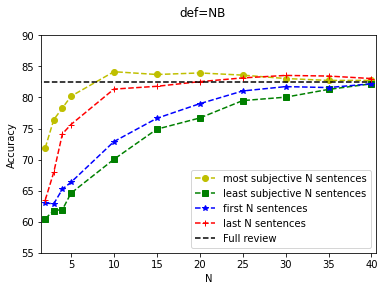

In [17]:
import matplotlib.pyplot as plt
accuracies = np.array(accuracies)
fig = plt.figure()
fig.suptitle('def=NB')
plt.xlabel('N')
plt.ylabel('Accuracy')
plt.plot(N, accuracies[:, 0], 'yo--', label='most subjective N sentences')
plt.plot(N, accuracies[:, 1], 'gs--', label='least subjective N sentences')
plt.plot(N, accuracies[:, 2], 'b*--', label='first N sentences')
plt.plot(N, accuracies[:, 3], 'r+--', label='last N sentences')
plt.plot(range(41), [full_review for _ in range(41)], color='black', linestyle='dashed', label='Full review')
plt.legend(loc='best')
plt.axis([1.5, 40.5, 55, 90])
fig.savefig('NB-NB.png')